In [1]:
#The code in this notebook was taken and modified from https://www.tensorflow.org/tutorials/generative/adversarial_fgsm
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

In [2]:
#To-do: Load different pretrained facial recognition models besides MobileNetV2
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

2021-11-24 14:50:36.357994: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


14548992/14536120 [==============================] - 10s 1us/step


In [4]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    image = image[None, ...]
    return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
    return decode_predictions(probs, top=1)[0][0]

In [5]:
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

98304/83281 [===================================] - 0s 1us/step


2021-11-24 14:51:41.340000: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


49152/35363 [=========================================] - 0s 1us/step


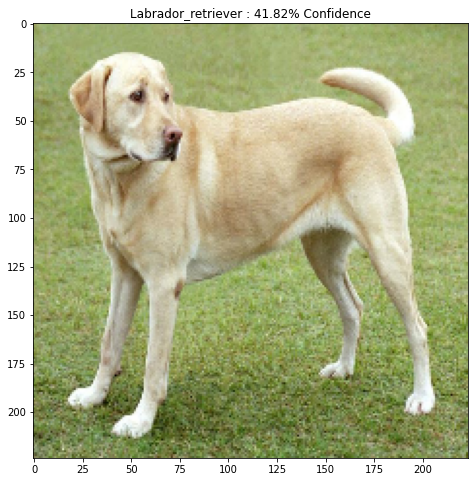

In [6]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

In [8]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = pretrained_model(input_image)
        loss = loss_object(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad

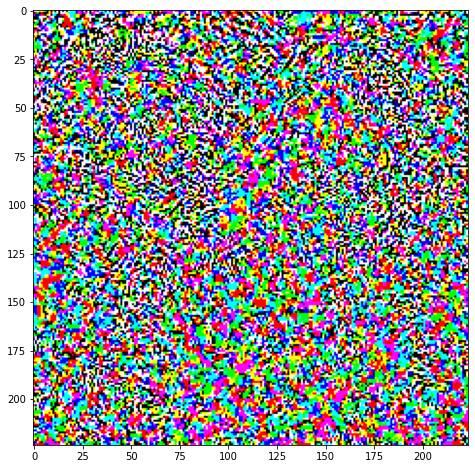

In [9]:
# Get the input label of the image.
labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

In [11]:
def display_images(image, description):
    _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
    plt.figure()
    plt.imshow(image[0]*0.5+0.5)
    plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
    plt.show()

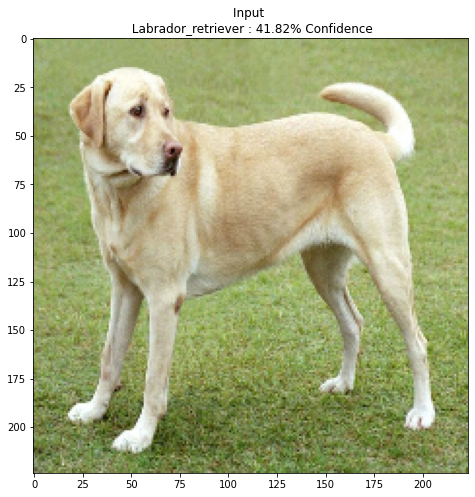

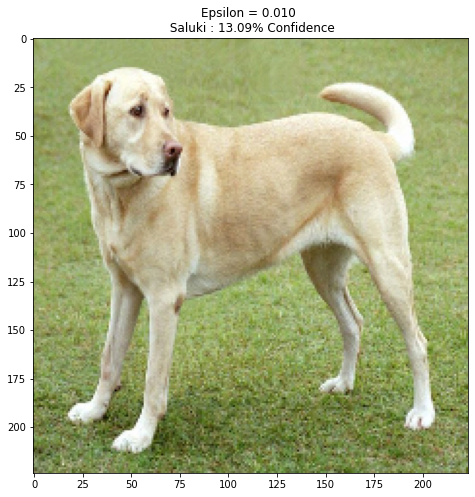

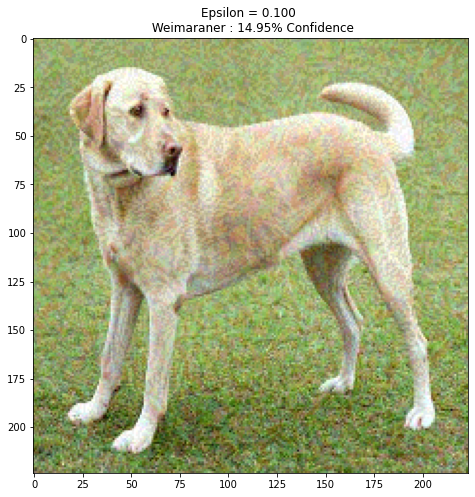

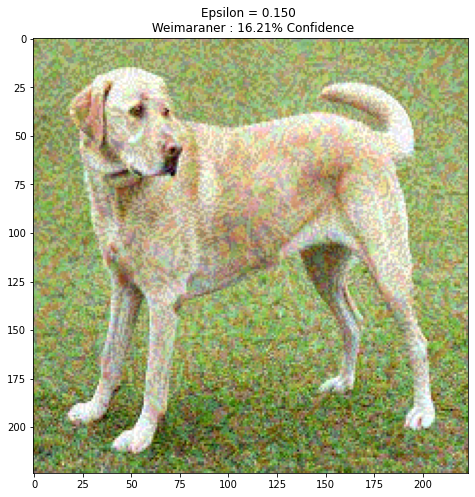

In [13]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
    adv_x = image + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    display_images(adv_x, descriptions[i])